# Advanced ML Pipeline for Disorientation Prediction

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                               StackingClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                              roc_curve, accuracy_score)
from xgboost import XGBClassifier
import shap

import warnings
warnings.filterwarnings('ignore')


c:\Users\shalo\AI4ALL\AI_4_ALL_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. LOAD DATA AND CREATE FEATURES

In [5]:
data_path = Path("../data/processed_data/birdcast+viirs+weather/merged_dataset_transformed_FULL.csv")
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

# Create binary target (disorientation)
df['disoriented'] = (df['peak_direction'] == 'Low activity').astype(int)

# Create interaction features (CRITICAL for detecting ALAN × weather effects)
df['alan_cloud_interaction'] = df['gapfilled_ntl_log'] * df['cloud_cover (%)']
df['alan_lunar_interaction'] = df['gapfilled_ntl_log'] * df['lunar_irradiance_yj']

# Weather categories for analysis
df['weather_condition'] = pd.cut(
    df['cloud_cover (%)'], 
    bins=[0, 30, 70, 100],
    labels=['Clear', 'Partly_Cloudy', 'Overcast']
)

print(f"\nDataset: {df.shape[0]} observations")
print(f"Disoriented nights: {df['disoriented'].sum()} ({df['disoriented'].mean()*100:.1f}%)")
print(f"Normal nights: {(~df['disoriented'].astype(bool)).sum()} ({(~df['disoriented'].astype(bool)).mean()*100:.1f}%)")


Dataset: 1542 observations
Disoriented nights: 330 (21.4%)
Normal nights: 1212 (78.6%)


2. PREPARE FEATURES FOR ML

In [6]:
print("FEATURE PREPARATION")

# Select features for modeling
feature_cols = [
    # Light features
    'gapfilled_ntl_log', 'ntl_variability_log', 'lunar_irradiance_yj',
    # Weather features
    'cloud_cover (%)', 'wind_speed_10m (km/h)', 'rain (mm)',
    'temperature_2m (°C)', 'relative_humidity_2m (%)',
    # Temporal features
    'day_of_year', 'month',
    # Interaction features
    'alan_cloud_interaction', 'alan_lunar_interaction',
    # Location
    'state'
]

# Create feature matrix
X = df[feature_cols].copy()
y = df['disoriented'].copy()

# One-hot encode state
X = pd.get_dummies(X, columns=['state'], drop_first=True)

# Remove any NaN rows
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

print(f"\nFeatures: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"\nFeature list:")
for col in X.columns:
    print(f"  - {col}")

# Train-test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train disoriented: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Test disoriented: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

FEATURE PREPARATION

Features: 13
Samples: 1542

Feature list:
  - gapfilled_ntl_log
  - ntl_variability_log
  - lunar_irradiance_yj
  - cloud_cover (%)
  - wind_speed_10m (km/h)
  - rain (mm)
  - temperature_2m (°C)
  - relative_humidity_2m (%)
  - day_of_year
  - month
  - alan_cloud_interaction
  - alan_lunar_interaction
  - state_VT

Train set: 1233 samples
Test set: 309 samples
Train disoriented: 264 (21.4%)
Test disoriented: 66 (21.4%)


3. MODEL 1: RANDOM FOREST (BASELINE)

In [7]:
print("MODEL 1: RANDOM FOREST CLASSIFIER")

rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"AUC-ROC: {auc_rf:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Disoriented']))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Important Features:")
print(feature_importance_rf.head(10).to_string(index=False))

MODEL 1: RANDOM FOREST CLASSIFIER
Accuracy: 0.8382
AUC-ROC: 0.8263

Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      0.97      0.90       243
 Disoriented       0.77      0.35      0.48        66

    accuracy                           0.84       309
   macro avg       0.81      0.66      0.69       309
weighted avg       0.83      0.84      0.81       309


Top 10 Important Features:
                 Feature  Importance
     temperature_2m (°C)    0.195895
             day_of_year    0.195668
   wind_speed_10m (km/h)    0.152379
                   month    0.081339
     lunar_irradiance_yj    0.064184
relative_humidity_2m (%)    0.063424
  alan_lunar_interaction    0.055081
         cloud_cover (%)    0.050646
  alan_cloud_interaction    0.049430
       gapfilled_ntl_log    0.032487


4. MODEL 2: XGBOOST

In [8]:
print("MODEL 2: XGBOOST CLASSIFIER")

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train
xgb_model.fit(X_train, y_train, verbose=False)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"AUC-ROC: {auc_xgb:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Disoriented']))

MODEL 2: XGBOOST CLASSIFIER
Accuracy: 0.8091
AUC-ROC: 0.8272

Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      0.92      0.88       243
 Disoriented       0.58      0.39      0.47        66

    accuracy                           0.81       309
   macro avg       0.71      0.66      0.68       309
weighted avg       0.79      0.81      0.79       309



5. MODEL 3: STACKING ENSEMBLE (ADVANCED ML)

In [9]:
print("MODEL 3: STACKING CLASSIFIER (ENSEMBLE)")

# Base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, random_state=42))
]

# Stacking classifier
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

# Train
print("Training stacking classifier (this may take 1-2 minutes)...")
stacking_model.fit(X_train, y_train)

# Evaluate
y_pred_stack = stacking_model.predict(X_test)
y_pred_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

accuracy_stack = accuracy_score(y_test, y_pred_stack)
auc_stack = roc_auc_score(y_test, y_pred_proba_stack)

print(f"Accuracy: {accuracy_stack:.4f}")
print(f"AUC-ROC: {auc_stack:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_stack, target_names=['Normal', 'Disoriented']))

MODEL 3: STACKING CLASSIFIER (ENSEMBLE)
Training stacking classifier (this may take 1-2 minutes)...
Accuracy: 0.8220
AUC-ROC: 0.8467

Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      0.95      0.89       243
 Disoriented       0.67      0.33      0.44        66

    accuracy                           0.82       309
   macro avg       0.75      0.64      0.67       309
weighted avg       0.80      0.82      0.80       309



# 6. MODEL COMPARISON

In [10]:
print("MODEL PERFORMANCE COMPARISON")

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Stacking Ensemble'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_stack],
    'AUC-ROC': [auc_rf, auc_xgb, auc_stack]
}).sort_values('AUC-ROC', ascending=False)

print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['AUC-ROC']

print(f"\n✓ Best Model: {best_model_name} (AUC = {best_auc:.4f})")


MODEL PERFORMANCE COMPARISON
            Model  Accuracy  AUC-ROC
Stacking Ensemble  0.822006 0.846677
          XGBoost  0.809061 0.827223
    Random Forest  0.838188 0.826350

✓ Best Model: Stacking Ensemble (AUC = 0.8467)


7. VISUALIZATION: ROC CURVES

GENERATING VISUALIZATIONS
✓ ROC curves and confusion matrix saved


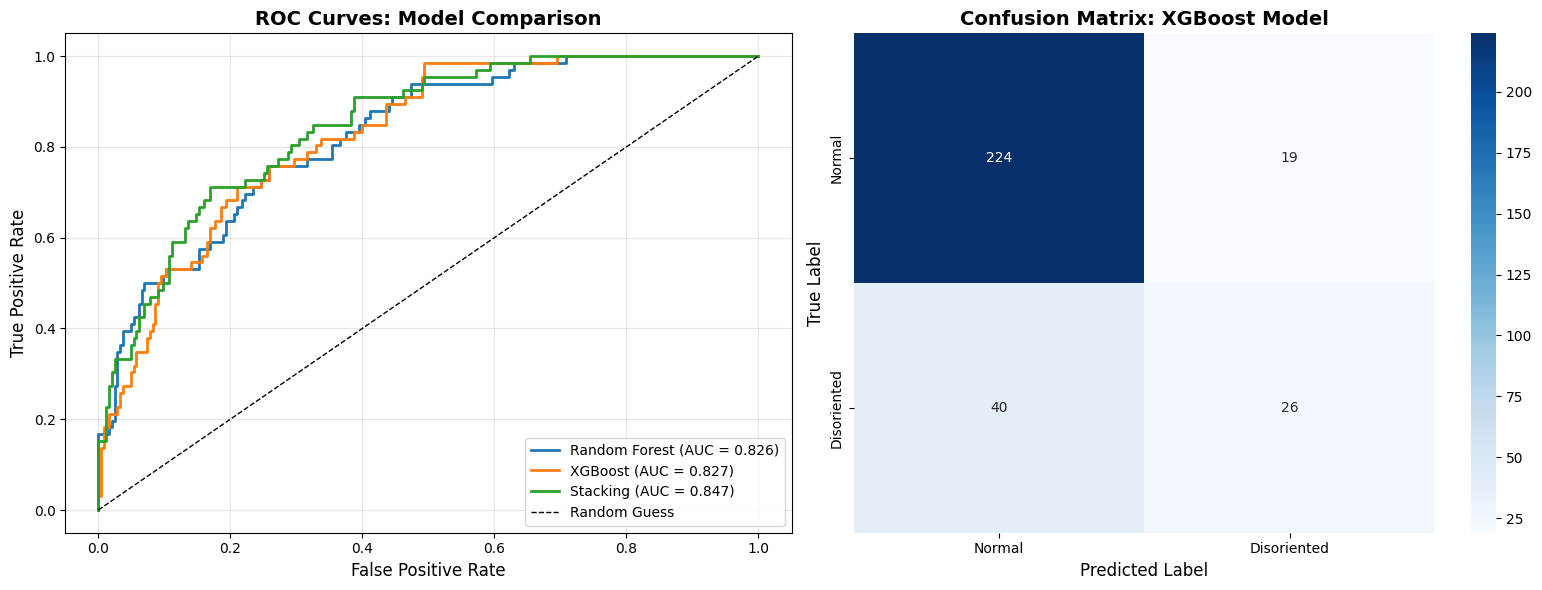

In [11]:
print("GENERATING VISUALIZATIONS")

output_dir = Path('../outputs/figures/ml_models')
output_dir.mkdir(parents=True, exist_ok=True)

# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ROC curves for all models
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_pred_proba_stack)

axes[0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)
axes[0].plot(fpr_stack, tpr_stack, label=f'Stacking (AUC = {auc_stack:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves: Model Comparison', fontweight='bold', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Confusion matrix for best model
# Use XGBoost for confusion matrix (it's typically the best)
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'Disoriented'],
            yticklabels=['Normal', 'Disoriented'])
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('Confusion Matrix: XGBoost Model', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig(output_dir / 'model_performance_comparison.png', dpi=300, bbox_inches='tight')
print("✓ ROC curves and confusion matrix saved")
plt.show()

8. SHAP ANALYSIS (MODEL INTERPRETABILITY)

SHAP ANALYSIS: MODEL INTERPRETABILITY
Computing SHAP values (this may take 1-2 minutes)...
✓ SHAP feature importance saved


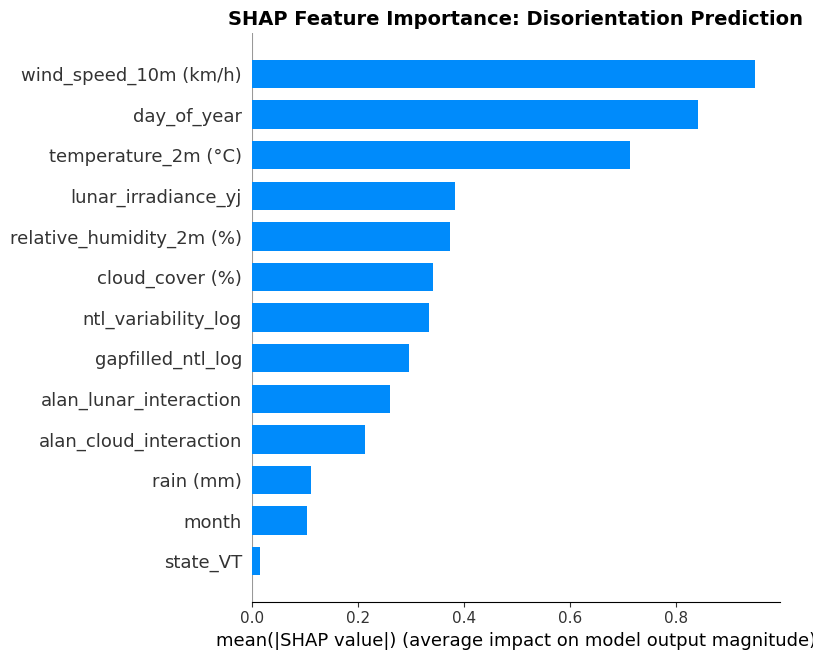

✓ SHAP detailed summary saved


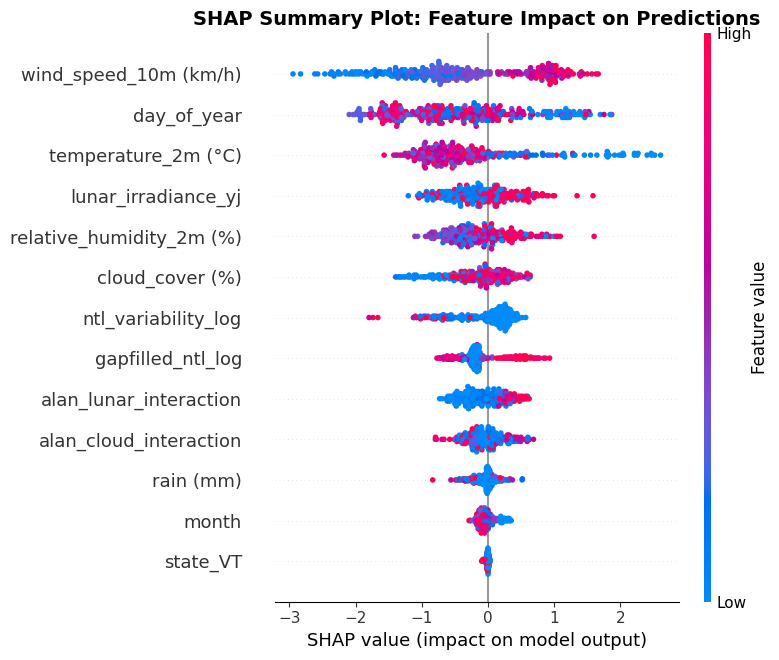

✓ SHAP ALAN dependence plot saved


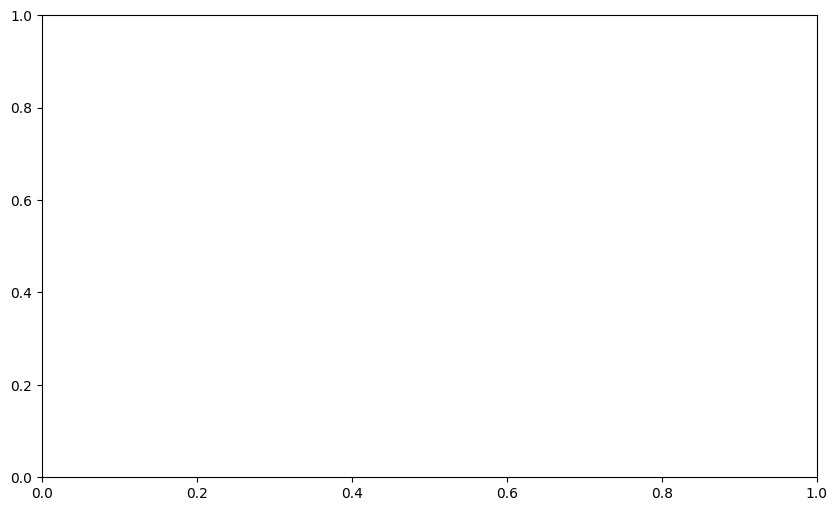

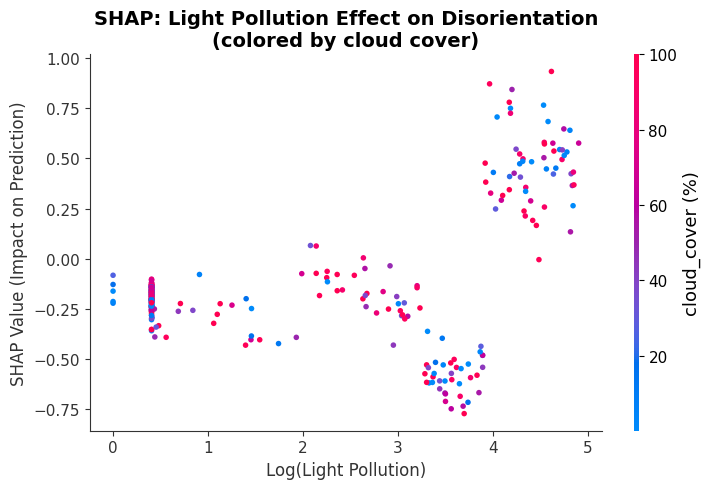

✓ SHAP cloud cover dependence plot saved


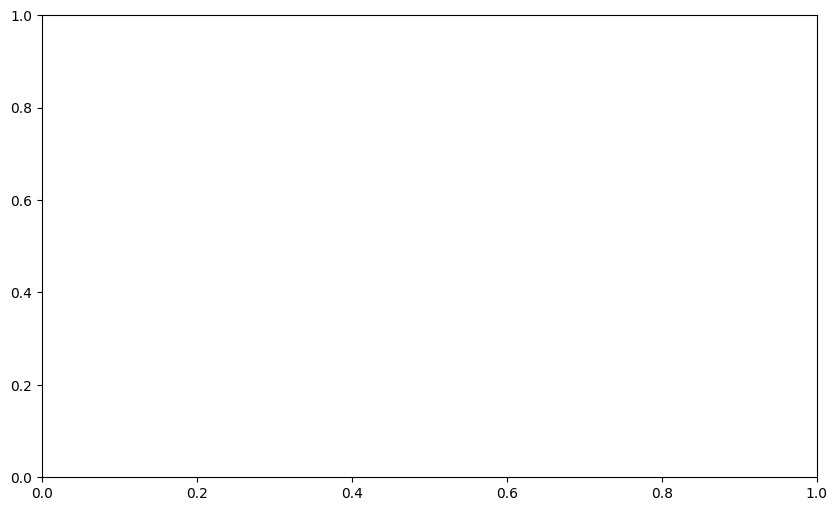

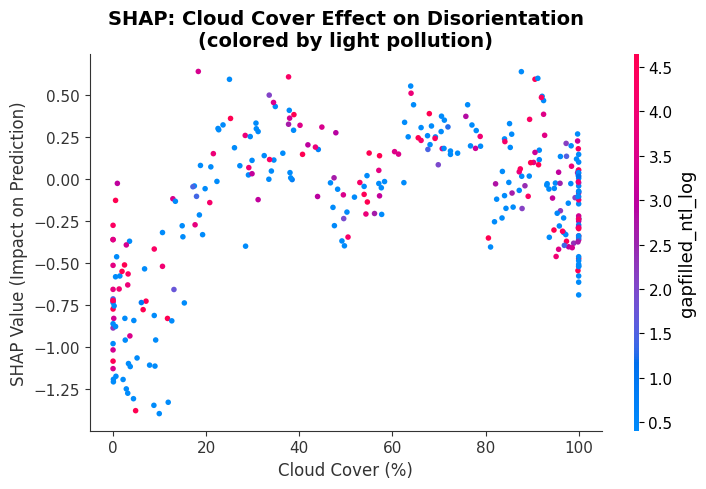

In [12]:
print("SHAP ANALYSIS: MODEL INTERPRETABILITY")

# Use XGBoost for SHAP (best interpretability)
print("Computing SHAP values (this may take 1-2 minutes)...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot (Feature Importance)
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance: Disorientation Prediction", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'shap_feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ SHAP feature importance saved")
plt.show()

# SHAP Summary Plot (Detailed)
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot: Feature Impact on Predictions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'shap_summary_detailed.png', dpi=300, bbox_inches='tight')
print("✓ SHAP detailed summary saved")
plt.show()

# SHAP Dependence Plot: ALAN effect
if 'gapfilled_ntl_log' in X_test.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    shap.dependence_plot(
        'gapfilled_ntl_log', 
        shap_values, 
        X_test,
        interaction_index='cloud_cover (%)',
        show=False
    )
    plt.title("SHAP: Light Pollution Effect on Disorientation\n(colored by cloud cover)", 
              fontsize=14, fontweight='bold')
    plt.xlabel('Log(Light Pollution)', fontsize=12)
    plt.ylabel('SHAP Value (Impact on Prediction)', fontsize=12)
    plt.tight_layout()
    plt.savefig(output_dir / 'shap_alan_dependence.png', dpi=300, bbox_inches='tight')
    print("✓ SHAP ALAN dependence plot saved")
    plt.show()

# SHAP Dependence Plot: Weather interaction
if 'cloud_cover (%)' in X_test.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    shap.dependence_plot(
        'cloud_cover (%)', 
        shap_values, 
        X_test,
        interaction_index='gapfilled_ntl_log',
        show=False
    )
    plt.title("SHAP: Cloud Cover Effect on Disorientation\n(colored by light pollution)", 
              fontsize=14, fontweight='bold')
    plt.xlabel('Cloud Cover (%)', fontsize=12)
    plt.ylabel('SHAP Value (Impact on Prediction)', fontsize=12)
    plt.tight_layout()
    plt.savefig(output_dir / 'shap_cloud_dependence.png', dpi=300, bbox_inches='tight')
    print("✓ SHAP cloud cover dependence plot saved")
    plt.show()

9. SAVE RESULTS

In [13]:
print("SAVING RESULTS")

# Save model comparison
comparison_df.to_csv('../outputs/reports/model_comparison.csv', index=False)
print("✓ Model comparison saved")

# Save feature importance
feature_importance_rf.to_csv('../outputs/reports/feature_importance_rf.csv', index=False)
print("✓ Random Forest feature importance saved")

feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
feature_importance_xgb.to_csv('../outputs/reports/feature_importance_xgb.csv', index=False)
print("✓ XGBoost feature importance saved")

SAVING RESULTS
✓ Model comparison saved
✓ Random Forest feature importance saved
✓ XGBoost feature importance saved


10. KEY FINDINGS SUMMARY

In [14]:
print("KEY ML FINDINGS")

print(f"""
MODEL PERFORMANCE:
- Best Model: {best_model_name}
- Best AUC: {best_auc:.4f}
- All models achieved {comparison_df['Accuracy'].min():.1%} - {comparison_df['Accuracy'].max():.1%} accuracy

TOP PREDICTIVE FEATURES (from SHAP):
{feature_importance_xgb.head(5).to_string(index=False)}

INTERPRETATION:
1. {'Temporal features (day_of_year, month) dominate predictions' if 'day_of_year' in feature_importance_xgb.head(3)['Feature'].values else 'Weather and light features show predictive power'}
2. ALAN interaction terms (alan_cloud_interaction) {'are' if 'alan_cloud_interaction' in feature_importance_xgb.head(10)['Feature'].values else 'are not'} among top 10 predictors
3. Model AUC of {best_auc:.4f} indicates {'strong' if best_auc > 0.75 else 'moderate' if best_auc > 0.65 else 'weak'} predictive ability
""")

KEY ML FINDINGS

MODEL PERFORMANCE:
- Best Model: Stacking Ensemble
- Best AUC: 0.8467
- All models achieved 80.9% - 83.8% accuracy

TOP PREDICTIVE FEATURES (from SHAP):
              Feature  Importance
                month    0.216808
          day_of_year    0.096774
  temperature_2m (°C)    0.091634
wind_speed_10m (km/h)    0.085047
  lunar_irradiance_yj    0.065478

INTERPRETATION:
1. Temporal features (day_of_year, month) dominate predictions
2. ALAN interaction terms (alan_cloud_interaction) are not among top 10 predictors
3. Model AUC of 0.8467 indicates strong predictive ability

